# 1. 필요한 패키지 로드

In [69]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from IPython.display import clear_output
from PIL import Image

import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))

tensorflow version: 2.1.0


# 2. 데이터셋 경로, 파라미터 선언

In [70]:
data_dir = './data/dataset'  # 압축 해제된 데이터셋의 디렉토리 경로
print_steps = 1
val_epoch = 1

batch_size = 20
max_epochs = 20
learning_rate = 1e-4
IMG_SIZE = 150

PATH = data_dir

# 3. Input pipeline , 데이터 증식 함수 선언 

In [71]:
 # 해당경로의 파일을 읽어서 float 타입으로 변환하는 함수
def load(image_file, label):
   
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)

    return image, label

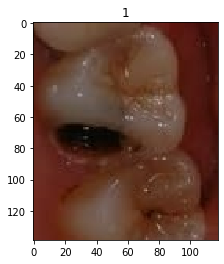

In [72]:
#확인용 코드
image, label = load(os.path.join(PATH, 'train/cavity/59.jpg'), 1)
plt.figure()
plt.title(label)
plt.imshow(image/255.0)
plt.show()

In [73]:
  # 원하는 height와 width로 이미지를 resize 하는 함수
def resize(input_image, height, width):
  
    input_image = tf.image.resize(input_image,[height,width])

    return input_image

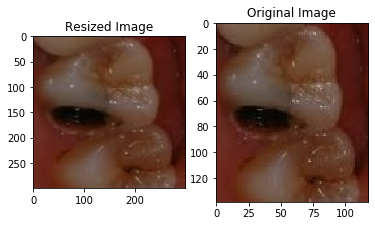

In [74]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("Resized Image")
plt.imshow(resize(image, 300, 300)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [75]:
 # 이미지를 랜덤한 각도(radian)로 회전 시키는 함수
def random_rotation(input_image):
   
    angles = np.random.randint(3)
    rotated_image = tf.image.rot90(input_image,angles)

    return rotated_image

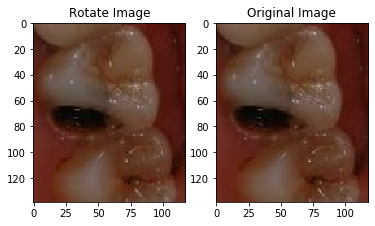

In [76]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("Rotate Image")
plt.imshow(random_rotation(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [77]:
#영역 추출 함수
def random_crop(input_image):

    cropped_image = tf.image.random_crop(input_image,[64,64,3])

    return cropped_image

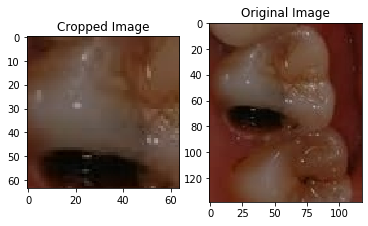

In [78]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("Cropped Image")
plt.imshow(random_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [79]:
# 이미지 픽셀값의 범위를 normalize 하는 함수 [0, 255] -> [-1, 1]
def normalize(input_image):
  

    input_image = (input_image/255)-1

    return input_image

In [80]:
 # resize, random_crop, random_rotation, random_flip 함수들 통합 함수
def random_jitter(input_image):
   
    input_image = resize(input_image,128,128)
    input_image = random_crop(input_image)
    input_image = random_rotation(input_image)    
    input_image = tf.image.random_flip_left_right(input_image)

    return input_image

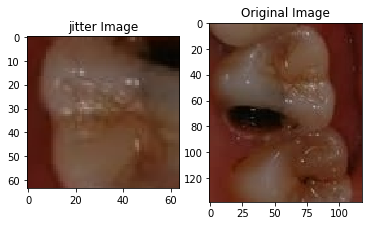

In [81]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("jitter Image")
plt.imshow(random_jitter(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [82]:
# 176 x 176 으로 resize후 150 x 150 중앙 crop 하는 함수
def central_crop(input_image):

    input_image = resize(input_image,128,128)
    input_image = tf.image.central_crop(input_image,0.50)

    return input_image

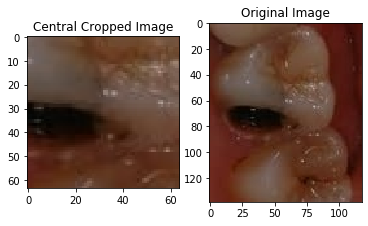

In [83]:
#확인용 코드
plt.figure()
plt.subplot(121)
plt.title("Central Cropped Image")
plt.imshow(central_crop(image)/255.0)
plt.subplot(122)
plt.title("Original Image")
plt.imshow(image/255.0)
plt.show()

In [84]:
#훈련 데이터 Input pipeline
def load_image_train(image_file, label):

    input_image, label = load(image_file,label)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)

    return input_image, label

In [85]:
#검증, 테스트 데이터 Input pipeline
def load_image_val_and_test(image_file, label):

    input_image, label = load(image_file,label)
    input_image = central_crop(input_image)
    input_image = normalize(input_image)

    return input_image, label

# 4. 데이터셋 

In [86]:
#라벨 붙이는 함수, 충치는 0 정상은 1
def add_label(image_file, label):
    return image_file, label

In [87]:
# train folder에 있는 폴더 이름을 list로 나타냅니다.
folder_list = [f for f in os.listdir(os.path.join(PATH, 'train')) if not f.startswith('.')]

1. `tf.data.Dataset.list_files`을 이용하여 첫번째 폴더('cavity')에 있는 `*.jpg`의 파일이름을 가져와서 `train_dataset`으로 만듭니다.
2. 해당 `dataset`에 `tf.data.Dataset.map`함수를 이용하여 label(0)을 추가합니다.
3. for문을 통해 `folder_list`에 있늘 폴더들을 두번째 부터 읽어옵니다.
4. `tf.data.Dataset.list_files`을 이용하여 두번째 폴더('normal')에 있는 `*.jpg`의 파일이름을 가져와서 `temp_dataset`으로 만듭니다.
5. 해당 `dataset`에 `tf.data.Dataset.map`함수를 이용하여 label(1)을 추가합니다.
6. `train_dataset`('cavity' 데이터)와 `temp_dataset`('normal' 데이터)를 `tf.data.Dataset.concatenate`를 이용하여 합칩니다.
7. for문을 반복합니다. (각 카테고리의 데이터와 label이 차례로 `train_dataset`에 합쳐집니다.)

In [88]:
train_dataset = tf.data.Dataset.list_files(                            # 1번
os.path.join(PATH, 'train', folder_list[0], '*.jpg'))
train_dataset = train_dataset.map(lambda x: add_label(x, 0))          # 2번
for label, category_name in enumerate(folder_list[1:], 1):            # 3번
    temp_dataset = tf.data.Dataset.list_files(                         # 4번
        os.path.join(PATH, 'train', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))    # 5번
    train_dataset = train_dataset.concatenate(temp_dataset)            # 6번

In [89]:
N = BUFFER_SIZE = len(list(train_dataset)) 
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=16)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [90]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'val')) if not f.startswith('.')]
val_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))
val_dataset = val_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'val', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    val_dataset = val_dataset.concatenate(temp_dataset)

val_dataset = val_dataset.map(load_image_val_and_test)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

In [91]:
folder_list = [f for f in os.listdir(os.path.join(PATH, 'test')) if not f.startswith('.')]
test_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))
test_dataset = test_dataset.map(lambda x: add_label(x, 0))
for label, category_name in enumerate(folder_list[1:], 1):
    temp_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test', category_name, '*.jpg'))
    temp_dataset = temp_dataset.map(lambda x: add_label(x, label))
    test_dataset = test_dataset.concatenate(temp_dataset)

test_dataset = test_dataset.map(load_image_val_and_test)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


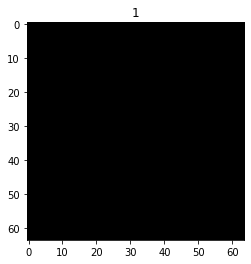

In [92]:
for images, labels in train_dataset.take(1):
    for j in range(1):
        plt.figure()
        plt.imshow(images[j]/255.0)
        plt.title(labels[j].numpy())
        plt.show()

# 5. 네트워크 설계

In [94]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()

        self.conv = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size)
        self.bn = tf.keras.layers.BatchNormalization() 
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D()

    def call(self, inputs, training=True):

        x = self.conv(inputs)  
        x = self.bn(x,training=training)    
        x = self.relu(x)    
        x = self.pool(x)    

        return x

In [95]:
model = tf.keras.Sequential()

model.add(Conv(filters=32, kernel_size=3))
model.add(Conv(filters=64, kernel_size=3))
model.add(Conv(filters=128, kernel_size=3))
model.add(Conv(filters=128, kernel_size=3))

model.add(tf.keras.layers.Flatten())  
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))  
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))  

In [96]:
model(images[:1])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.4910937 , 0.50890636]], dtype=float32)>

In [97]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_8 (Conv)                multiple                  1024      
_________________________________________________________________
conv_9 (Conv)                multiple                  18752     
_________________________________________________________________
conv_10 (Conv)               multiple                  74368     
_________________________________________________________________
conv_11 (Conv)               multiple                  148096    
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  262656    
_________________________________________________________________
dense_5 (Dense)              multiple                 

# 모델 저장

In [98]:
checkpoint_path = "./train/exp_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_weights_only=True, verbose=1)

# 6. Loss function 및 Optimizer 정의

In [99]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

# 7. Training

In [100]:
train_len = len(glob(os.path.join(PATH, 'train', folder_list[0], '*.jpg'))) * 2
val_len = len(glob(os.path.join(PATH, 'val', folder_list[0], '*.jpg'))) * 2
test_len = len(glob(os.path.join(PATH, 'test', folder_list[0], '*.jpg'))) * 2

In [102]:
history = model.fit(train_dataset, 
                    steps_per_epoch = train_len//batch_size,
                    validation_data=val_dataset, 
                    validation_steps=val_len//batch_size ,
                    epochs= max_epochs,
                    callbacks= [cp_callback])

Train for 23 steps, validate for 3 steps
Epoch 1/20
22/23 [===========================>..] - ETA: 0s - loss: 0.8046 - categorical_accuracy: 0.7062
Epoch 00001: saving model to ./train/exp_cnn
23/23 [==============================] - 15s 652ms/step - loss: 0.7956 - categorical_accuracy: 0.6968


InvalidArgumentError:  Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [64,64,3], [batch]: [64,64,4]
	 [[node IteratorGetNext (defined at <ipython-input-102-0d2ea21a3757>:6) ]] [Op:__inference_distributed_function_11172]

Function call stack:
distributed_function


In [61]:
def show_graph(history_dict):
    accuracy = history_dict['categorical_accuracy']
    val_accuracy = history_dict['val_categorical_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)


    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

    plt.show()

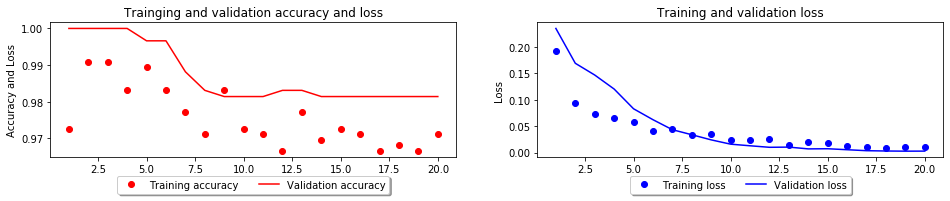

In [62]:
show_graph(history.history)

# 8. 평가

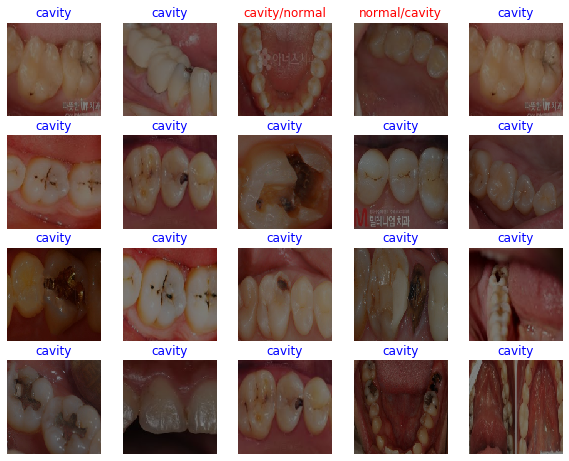

In [79]:
test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cavity', 1: 'normal'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')#정답
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')#오답
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

# 9. 저장된 모델 불러오기 및 Evaluation

In [8]:
model = tf.keras.Sequential()

model.add(Conv(filters=32, kernel_size=3))
model.add(Conv(filters=64, kernel_size=3))
model.add(Conv(filters=128, kernel_size=3))
model.add(Conv(filters=128, kernel_size=3))

model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax)) 



model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = [tf.keras.metrics.CategoricalAccuracy()])



#for images, labels in train_dataset.take(1):
 #   outputs = model(images, training=False)

In [11]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'./train/exp_cnn\\cp-0020.ckpt'

In [12]:
model.load_weights(latest)

In [52]:
model.evaluate(test_dataset, steps=test_len/batch_size)

27/26 [==============================] - 16s 583ms/step - loss: 0.1387 - categorical_accuracy: 0.9963


[0.13920045932097064, 0.9962963]

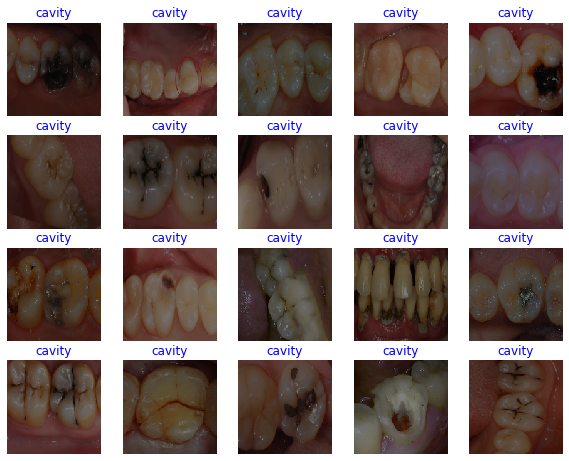

In [53]:
test_batch_size = 25

for images, labels in test_dataset.take(1):
    predictions = model(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cavity', 1: 'normal'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')#정답
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')#오답
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'reshape'

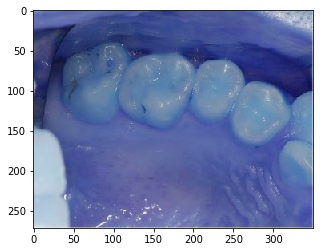

In [106]:
from tensorflow.keras.preprocessing.image import array_to_img

cls_index = ['정상치', '충치']

imgs = cv2.imread('./data/dataset/real/1.jpg')
plt.imshow(imgs)
imgs = central_crop(imgs)
imgs = normalize(imgs)

result = model.predict_classes(imgs.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))




In [83]:
import cv2

a = cv2.imread('./data/dataset/real/1.jpg')
a
#cv2.imshow('title', a)
#cv2.waitKey()

array([[[197, 214, 233],
        [168, 187, 208],
        [176, 194, 217],
        ...,
        [185, 199, 222],
        [185, 197, 221],
        [204, 217, 239]],

       [[165, 183, 206],
        [126, 144, 167],
        [128, 147, 174],
        ...,
        [145, 159, 182],
        [152, 164, 188],
        [193, 206, 228]],

       [[170, 188, 217],
        [117, 138, 166],
        [116, 137, 169],
        ...,
        [136, 150, 173],
        [143, 155, 179],
        [186, 199, 221]],

       ...,

       [[222, 231, 241],
        [207, 216, 226],
        [208, 217, 227],
        ...,
        [ 82,  87, 156],
        [ 86,  90, 155],
        [148, 153, 214]],

       [[226, 233, 242],
        [210, 219, 228],
        [211, 220, 229],
        ...,
        [ 84,  90, 157],
        [ 87,  92, 155],
        [145, 149, 208]],

       [[241, 248, 255],
        [228, 235, 244],
        [227, 236, 245],
        ...,
        [147, 153, 218],
        [146, 151, 212],
        [193, 197, 255]]

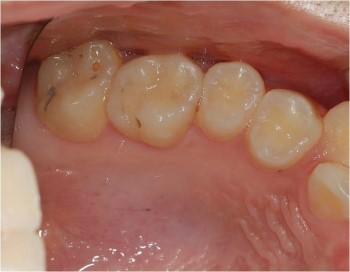

In [85]:
import PIL.Image as pilimg
a = pilimg.open('./data/dataset/real/1.jpg')
a

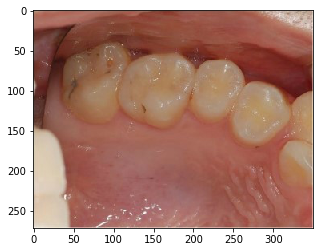

In [107]:
test1 = plt.imread('./data/dataset/real/1.jpg')
plt.imshow(test1);

In [117]:
test1 = plt.imread('./data/dataset/real/1.jpg')
test1 = test1[:,:,0]
#test1 = (test1 > 125) * test1
test1 = central_crop(test1)
test1 = test1.astype('float32') / 255.

plt.imshow(test1, cmap='Greys', interpolation='nearest')

test1 = test1.reshape((1, 64, 64, 3))

print('The Answer is ', model.predict_classes(test1))

ValueError: 'images' must have either 3 or 4 dimensions.